In [8]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# 📄 Step 2: Parse Train and Test Data
def parse_train_line(line):
    parts = line.strip().split(" ::: ")
    if len(parts) == 4:
        return {"id": parts[0], "title": parts[1], "genre": parts[2], "description": parts[3]}
    return None

def parse_test_line(line):
    parts = line.strip().split(" ::: ")
    if len(parts) == 3:
        return {"id": parts[0], "title": parts[1], "description": parts[2]}
    return None

# Load training data
with open('train_data.txt', 'r', encoding='utf-8') as f:
    train_lines = [parse_train_line(line) for line in f if parse_train_line(line)]
train_df = pd.DataFrame(train_lines)

# Load test data
with open('test_data.txt', 'r', encoding='utf-8') as f:
    test_lines = [parse_test_line(line) for line in f if parse_test_line(line)]
test_df = pd.DataFrame(test_lines)


In [4]:
print("Genres distribution in training data:")
print(train_df['genre'].value_counts())

# Optional: Clean descriptions (remove punctuation, lowercase, etc.)
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

train_df['description_clean'] = train_df['description'].apply(clean_text)
test_df['description_clean'] = test_df['description'].apply(clean_text)


Genres distribution in training data:
genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


In [13]:
# 🧹 Step 3: Clean Descriptions
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # remove punctuation and lowercase
    return text

train_df['description_clean'] = train_df['description'].apply(clean_text)
test_df['description_clean'] = test_df['description'].apply(clean_text)


In [12]:
# 📊 Step 4: TF-IDF with Bigrams and Trigrams
vectorizer = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=2,
    max_df=0.85
)
X = vectorizer.fit_transform(train_df['description_clean'])
y = train_df['genre']
X_test_final = vectorizer.transform(test_df['description_clean'])


In [14]:
# ⚖️ Step 5: Handle Imbalance with Oversampling
ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)


In [15]:
# 🧠 Step 6: Create and Train Ensemble Model
# Note: LinearSVC doesn't support probability, so use hard voting
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB()),
    ('svc', LinearSVC())
], voting='hard')  # use 'soft' if all models support predict_proba()

ensemble_model.fit(X_train, y_train)

# Predict on validation set
y_pred = ensemble_model.predict(X_val)


Accuracy: 0.9256437812028132

Classification Report:
               precision    recall  f1-score   support

      action       0.89      0.94      0.91      2722
       adult       0.96      1.00      0.98      2723
   adventure       0.93      0.99      0.96      2723
   animation       0.95      1.00      0.97      2723
   biography       0.95      1.00      0.98      2723
      comedy       0.74      0.67      0.70      2723
       crime       0.93      1.00      0.97      2723
 documentary       0.77      0.64      0.70      2723
       drama       0.64      0.44      0.53      2722
      family       0.92      0.98      0.95      2722
     fantasy       0.96      1.00      0.98      2723
   game-show       0.99      1.00      1.00      2722
     history       0.98      1.00      0.99      2722
      horror       0.91      0.92      0.92      2722
       music       0.95      0.99      0.97      2723
     musical       0.98      1.00      0.99      2723
     mystery       0.97    

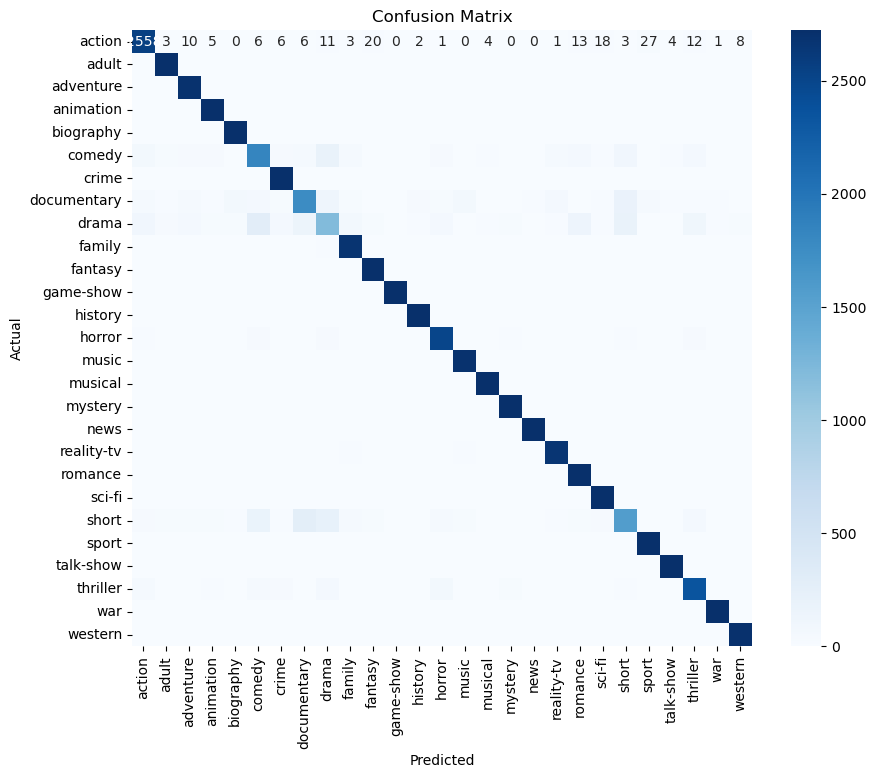

In [16]:
# 📈 Step 7: Evaluation Metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
labels = sorted(y.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# 🔮 Step 8: Predict on Final Test Data
test_df['predicted_genre'] = ensemble_model.predict(X_test_final)
print(test_df[['title', 'predicted_genre']].head())


                         title predicted_genre
0         Edgar's Lunch (1998)           short
1     La guerra de papá (1977)           drama
2  Off the Beaten Track (2010)     documentary
3       Meu Amigo Hindu (2015)           drama
4            Er nu zhai (1955)          action
